### Problem Set 3

In [1]:
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

#### 1(b). Estimate the parameters by GMM

In [4]:
incomes = np.loadtxt('incomes.txt')
incomes.shape

(200,)

In [18]:
def trunc_lognorm_pdf(xvals, mu, sigma, cutoff):
    if cutoff == 'None':
        prob_notcut = 1.0
    else:
        prob_notcut = sts.norm.cdf(cutoff, loc=mu, scale=sigma)
    
    lognorm_pdf_vals = ((1 / (xvals * sigma * np.sqrt(2 * np.pi)) *
                    np.exp(-(np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return lognorm_pdf_vals

In [65]:
def data_moments(xvals):
    mean_data = xvals.mean()
    std_data = xvals.std()
    
    return mean_data, std_data

#@ Pay attention to the lower band of lognormal is 0
test_ub = 15000000
#@ Why np.inf doesn't work?  
def model_moments(mu, sigma, cutoff):
    xfx = lambda x: x * trunc_lognorm_pdf(x, mu, sigma, cutoff)
    (mean_model, m_m_err) = intgr.quad(xfx, 0, test_ub)
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_lognorm_pdf(
                                                     x, mu, sigma, cutoff) 
    (var_model, v_m_err) = intgr.quad(x2fx, 0, test_ub)
    
    return mean_model, np.sqrt(var_model)


def err_vec(xvals, mu, sigma, cutoff, simple):
    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma, cutoff)
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion(params, *args):
    mu, sigma = params
    xvals, cutoff, W = args
    err = err_vec(xvals, mu, sigma, cutoff, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

* Guess initial values

In [17]:
print(incomes.mean(), incomes.std())
print(np.log(np.array([incomes.mean(), incomes.std()])))

85276.8236063 17992.542128
[ 11.35365799   9.79771262]


/Users/nerv/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in true_divide
/Users/nerv/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log
/Users/nerv/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in multiply


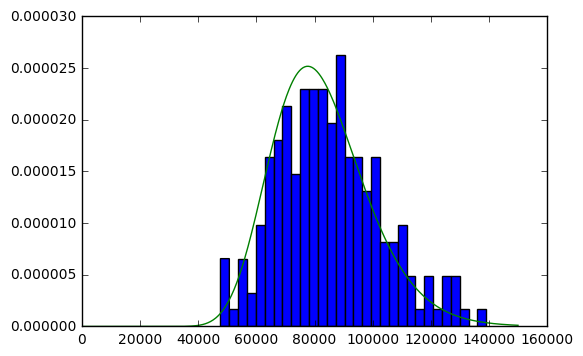

In [34]:
xvals_test = np.linspace(0, 150000, 500)
mu_test, sigma_test = 11.3, 0.2
plt.subplots()
plt.hist(incomes, 30, normed = True)
plt.plot(xvals_test, trunc_lognorm_pdf(xvals_test, mu_test, 
                                       sigma_test, 'None'))

In [77]:
mu_init, sig_init = 11.0, 0.2

params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (incomes, 'None', W_hat)
results = opt.minimize(criterion, params_init, args = gmm_args,
                       method = 'L-BFGS-B', 
                       bounds = ((1e-10, None), (1e-10, None)))
mu_GMM_1b, sig_GMM_1b = results.x
print('mu_GMM1=', mu_GMM_1b, ' sig_GMM1=', sig_GMM_1b)
results

mu_GMM1= 11.3318808796  sig_GMM1= 0.208696657968


      fun: array([[  1.52796931e-15]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.24638464e-07,   4.51714148e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 39
      nit: 10
   status: 0
  success: True
        x: array([ 11.33188088,   0.20869666])

/Users/nerv/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in true_divide
/Users/nerv/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/nerv/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in multiply


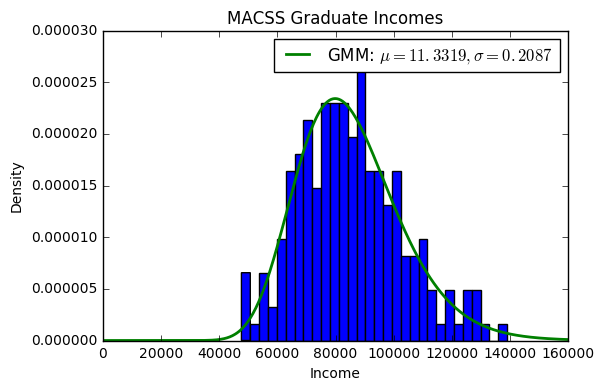

In [78]:
x_linspace = np.linspace(0, 160000, 500)

def plot_1b():
    plt.hist(incomes, 30, normed = True)
    plt.plot(x_linspace, trunc_lognorm_pdf(x_linspace, *results.x, 'None'),
             label = 'GMM: $\mu = {:.4f}, \sigma = {:.4f}$'.format(
             *results.x), lw = 2)
    plt.title('MACSS Graduate Incomes')
    plt.xlabel('Income')
    plt.ylabel('Density')
    plt.legend(loc = 'best')
    
plt.subplots()
plot_1b()

In [79]:
print('Data moments of mean and std: ', data_moments(incomes))
print('Model moments of mean and std: ', model_moments(*results.x, 'None'))

Data moments of mean and std:  (85276.823606258113, 17992.542128046523)
Model moments of mean and std:  (85276.82659818021, 17992.542438137243)


#### 1(c). 2-Step GMM

In [80]:
err_1c = err_vec(incomes, mu_GMM_1b, sig_GMM_1b, 'None', False)
VCV_1c = np.dot(err_1c, err_1c.T) / incomes.shape[0]
print('VCV Matrix: ')
print(VCV_1c)
W_hat_1c = lin.pinv(VCV_1c)  # Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
print('W_hat (inverted VCV): ')
print(W_hat_1c)

VCV Matrix: 
[[  6.15472335e-18   3.02332971e-18]
 [  3.02332971e-18   1.48512321e-18]]
W_hat (inverted VCV): 
[[  1.05448223e+17   5.17983873e+16]
 [  5.17983873e+16   2.54444585e+16]]


In [92]:
params_init_1c = results.x
gmm_args_1c = (incomes, "None", W_hat_1c)
results_1c = opt.minimize(criterion, params_init_1c, args = gmm_args_1c,
                       method='L-BFGS-B', 
                       bounds=((1e-10, None), (1e-10, None)))
results_1c

      fun: array([[  2.12856102e-05]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.34042677e+09,   7.77384542e+09])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 171
      nit: 4
   status: 2
  success: False
        x: array([ 11.33188088,   0.20869664])

In [95]:
opt.minimize(criterion, params_init_1c, args = gmm_args_1c, method='TNC')

     fun: array([[ 4.48204137]])
     jac: array([  4.39525267e+09,   1.15171793e+10])
 message: 'Converged (|x_n-x_(n-1)| ~= 0)'
    nfev: 4
     nit: 1
  status: 2
 success: True
       x: array([ 11.33188086,   0.20869666])

In [104]:
print('The value of the criterion function is: {}'.format(
      float(criterion(results_1c.x, *gmm_args_1c))))

The value of the criterion function is: 2.1285610191427995e-05


/Users/nerv/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:36: RuntimeWarning: divide by zero encountered in true_divide
/Users/nerv/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:37: RuntimeWarning: divide by zero encountered in log
/Users/nerv/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:37: RuntimeWarning: invalid value encountered in multiply


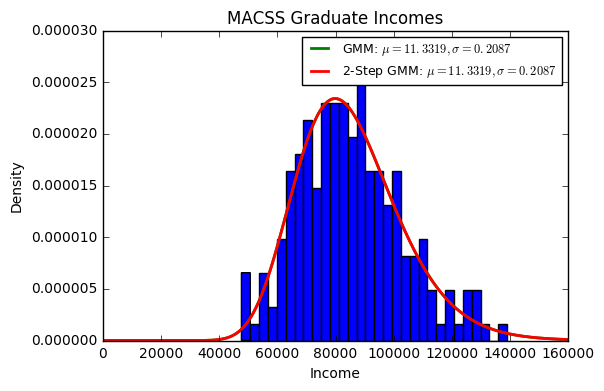

In [112]:
plt.subplots()

plot_1b()
plt.plot(x_linspace, trunc_lognorm_pdf(x_linspace, *results_1c.x, 'None'),
             label = '2-Step GMM: $\mu = {:.4f}, \sigma = {:.4f}$'.format(
             *results_1c.x), lw = 2)
plt.legend(prop = {'size': 9})

#### extra: 3D plot of the criterion function

In [113]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
cmap1 = matplotlib.cm.get_cmap('summer')

/Users/nerv/anaconda/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/nerv/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:57: RuntimeWarning: invalid value encountered in sqrt
/Users/nerv/anaconda/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if ful

/Users/nerv/anaconda/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


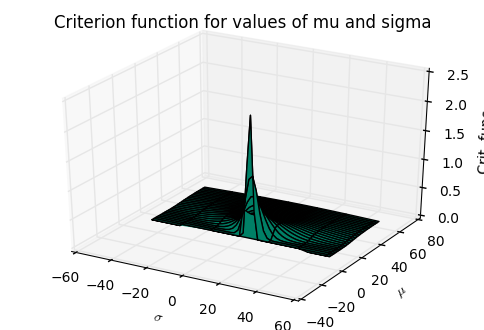

In [115]:
margin = 50
mu_vals = np.linspace(results_1c.x[0]-margin, results_1c.x[0]+margin, margin)
sig_vals = np.linspace(results_1c.x[1]-margin, results_1c.x[1]+margin, margin)

crit_vals = np.zeros((50, 50))
for mu_ind in range(50):
    for sig_ind in range(50):
        crit_vals[mu_ind, sig_ind] = \
            criterion(np.array([mu_vals[mu_ind], sig_vals[sig_ind]]),
                      incomes, 'None', W_hat_1c)

mu_mesh, sig_mesh = np.meshgrid(mu_vals, sig_vals)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(sig_mesh, mu_mesh, crit_vals, rstride=8,
                cstride=1, cmap=cmap1)
ax.set_title('Criterion function for values of mu and sigma')
ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'$\mu$')
ax.set_zlabel(r'Crit. func.')

#### 1(d). Alternative moments

In [144]:
def data_moments4(xvals):
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >= 75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = xvals[xvals >= 100000].shape[0] / xvals.shape[0]

    return bpct_1_dat, bpct_2_dat, bpct_3_dat


def model_moments4(mu, sigma, cutoff):
    xfx = lambda x: trunc_lognorm_pdf(x, mu, sigma, cutoff)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, 1e+10)
    # np.inf will cause some error
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod


def err_vec4(xvals, mu, sigma, cutoff, simple):
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments4(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments4(mu, sigma, cutoff)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
                           
    if simple:
        err_vec = moms_model - moms_data   # in case the denominator = 0
    else:
        err_vec = 100 * ((moms_model - moms_data) / moms_data)
        # Percentage
    
    return err_vec


def criterion4(params, *args):
    mu, sigma = params
    xvals, cutoff, W = args
    err = err_vec4(xvals, mu, sigma, cutoff, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

In [145]:
print(data_moments4(incomes))
print(model_moments4(11.33, 0.21, 'None'))
params = np.array([11.33, 0.21])
print(criterion4(params, incomes, 150000, np.eye(3)))

(0.3, 0.5, 0.2)
(0.3089457048264477, 0.4991973229364228, 2.9380948987325335e-117)
[[ 10008.91750882]]


In [146]:
params_init = np.array([11.33, 0.21])
W_hat_1d = np.eye(3)
gmm_args = (incomes, 150000, W_hat_1d)
results_1d = opt.minimize(criterion4, params_init, args=(gmm_args),
                       method='L-BFGS-B', 
                          bounds=((1e-10, None), (1e-10, None)))
results_1d

      fun: array([[ 10000.]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00236469, -0.00218279])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 21
      nit: 4
   status: 0
  success: True
        x: array([ 11.33568132,   0.21059844])

#### 1(e). Alternative 2-step GMM

In [147]:
err_1e = err_vec4(incomes, *results_1d.x, 'None', False)
VCV_1e = np.dot(err_1e, err_1e.T) / incomes.shape[0]
print(VCV_1e)
W_hat_1e = lin.pinv(VCV_1e)  # Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
print(W_hat_1e) 

[[  1.25132370e-14   5.54025883e-14  -7.90987896e-07]
 [  5.54025883e-14   2.45295984e-13  -3.50211353e-06]
 [ -7.90987896e-07  -3.50211353e-06   5.00000000e+01]]
[[  5.00529496e-18   2.21610353e-17  -3.16395158e-10]
 [  2.21610360e-17   9.81183936e-17  -1.40084541e-09]
 [ -3.16395168e-10  -1.40084541e-09   2.00000000e-02]]


### 2. Linear regression and GMM

In [93]:
plot = False


# Problem 1

income = np.loadtxt('incomes.txt')


# 1a

cutoff = 150000
lower_bound = 0.00
upper_bound = 150000
nums = 150000

if plot:
    fig, ax = plt.subplots()
    count, bins, ignored = plt.hist(income, 30, normed = True)
    plt.xlim(0, cutoff)
    plt.title("MACSS Class of '18, '19, '20 Graduate Salary")
    plt.xlabel(r'Income ($)')
    plt.ylabel('Probability Mass')
    plt.savefig('fig_1a')
    plt.close()

    
# 1b

def trunc_lognorm_pdf(xvals, mu, sigma, cutoff):
    
    if cutoff == 'None':
        prob_notcut = 1.0
    else:
        prob_notcut = sts.norm.cdf(cutoff, loc=mu, scale=sigma)
    
    lognorm_pdf_vals = ((1/(xvals*sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return lognorm_pdf_vals

def data_moments(xvals):
    
    mean_data = xvals.mean()
    std_data = xvals.std()
    
    return mean_data, std_data


def model_moments(mu, sigma, cutoff):
    
    xfx = lambda x: x * trunc_lognorm_pdf(x, mu, sigma, cutoff)
    (mean_model, m_m_err) = intgr.quad(xfx, 0, 15000000) 
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_lognorm_pdf(x, mu, sigma,
                                                                 cutoff) 
    (var_model, v_m_err) = intgr.quad(x2fx, 0, 15000000)
    std_model = np.sqrt(var_model)
    s_m_err = np.sqrt(v_m_err)
    
    return mean_model, std_model


def err_vec(xvals, mu, sigma, cutoff, simple):
    
    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma, cutoff)
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion(params, *args):
    
    mu, sigma = params
    xvals, cutoff, W = args
    err = err_vec(xvals, mu, sigma, cutoff, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 

    return crit_val


mu_init, sig_init = 11.0, 0.2

params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (income, 150000, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B',
                       bounds=((1e-10, None), (1e-10, None)))

mu_GMM1, sig_GMM1 = results.x

params_GMM1 = np.array([mu_GMM1, sig_GMM1])
value1 = criterion(params_GMM1, *gmm_args)[0,0]

mean_data, std_data = data_moments(income)
mean_model, std_model = model_moments(mu_GMM1, sig_GMM1, 150000)

print('1b.')
print('mu_GMM: {:.2f}'.format(mu_GMM1), 'sig_GMM: {:.2f}'.format(
       sig_GMM1))
print('The value of the GMM criterion function: {}'.format(value1))
print('Data moments: mu: {:.2f}, std: {:.2f}'.format(mean_data, std_data))
print('Model moments: mu: {:.2f}, std: {:.2f}\n'.format(mean_model, std_model))

dist_income = np.linspace(lower_bound, upper_bound, nums)

if plot:
    fig, ax = plt.subplots()
    count, bins, ignored = plt.hist(income, 30, normed = True)
    
    plt.title('PDF of Graduate Incomes of MACSS Students')
    plt.xlabel(r'Income ($)')
    plt.ylabel('Density')

    plt.plot(dist_income, trunc_lognorm_pdf(dist_income, mu_GMM1, sig_GMM1,
                150000), label = 'GMM: $\mu = {:.2f}, \sigma = {:.2f}$'.format(
                    mu_GMM1, sig_GMM1))
    
    plt.xlim(0, cutoff)
    plt.legend(loc='best')
    plt.savefig('fig_1b')
    plt.close()


# 1c

err1 = err_vec(income, mu_GMM1, sig_GMM1, 150000, False)
VCV2 = np.dot(err1, err1.T) / income.shape[0]
W_hat2 = lin.pinv(VCV2)  

params_init = np.array([mu_GMM1, sig_GMM1])
gmm_args2 = (income, 150000, W_hat2)
results2 = opt.minimize(criterion, params_init, args=(gmm_args2),
                        method='L-BFGS-B', 
                        bounds=((1e-10, None), (1e-10, None)))

mu_GMM2, sig_GMM2 = results2.x

params_init_GMM2 = np.array([mu_GMM2, sig_GMM2])
value2 = criterion(params_init_GMM2, *gmm_args2)[0,0]

mean_model2, std_model2 = model_moments(mu_GMM2, sig_GMM2, 150000)

if plot:
    fig, ax = plt.subplots()
    count, bins, ignored = plt.hist(income, 30, normed = True)
    plt.xlim(0, cutoff)
    plt.title('PDF of Graduate Incomes of MACSS Students')
    plt.xlabel(r'Income ($)')
    plt.ylabel('Density')

    plt.plot(dist_income, trunc_lognorm_pdf(
               dist_income, mu_GMM1, sig_GMM1,150000),
              label='GMM: $\mu = {:.2f}, \sigma = {:.2f}$'.format(mu_GMM1,
                                                                  sig_GMM1))

    plt.plot(dist_income, trunc_lognorm_pdf(dist_income, mu_GMM2, sig_GMM2,
              150000),label='2-Step GMM: $\mu = {:.2f}, \sigma = {:.2f}$'.\
               format(mu_GMM2, sig_GMM2))
    
    plt.legend(loc='best')
    plt.savefig('fig_1c')
    plt.close()

1b.
mu_GMM: 11.33 sig_GMM: 0.21
The value of the GMM criterion function: 1.527969312041055e-15
Data moments: mu: 85276.82, std: 17992.54
Model moments: mu: 85276.83, std: 17992.54



In [131]:
cutoff = 150000

def data_moments3(xvals):
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = (xvals[(xvals >=100000)].shape[0] /
                  xvals.shape[0])
   
    return bpct_1_dat, bpct_2_dat, bpct_3_dat


def model_moments3(mu, sigma, cutoff):
    xfx = lambda x: trunc_lognorm_pdf(x, mu, sigma, cutoff)
    # use small enough figure to lower bound 
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0.00001, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    # use large enough figure to upper bound
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, 1500000)  

    return bpct_1_mod, bpct_2_mod, bpct_3_mod


def err_vec3(xvals, mu, sigma, cutoff, simple):
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma, cutoff)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])

    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = 100 * ((moms_model - moms_data) / moms_data)
    
    return err_vec


def criterion3(params, *args):
    mu, sigma = params
    xvals, cutoff, W = args
    err = err_vec3(xvals, mu, sigma, cutoff, simple = True)
    crit_val = np.dot(np.dot(err.T, W), err) 
    return crit_val


W_hat_1d = np.eye(3)
gmm_args_1d = (income, cutoff, W_hat_1d)
results_1d = opt.minimize(criterion3, params_init, args=(gmm_args_1d),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))


mu_GMM_1d, sig_GMM_1d = results_1d.x

params_init_GMM_1d = np.array([mu_GMM_1d, sig_GMM_1d])
value3 = criterion3(params_init_GMM_1d, *gmm_args_1d)[0][0]

data_moment1, data_moment2, data_moment3 = data_moments3(income)
model_moment1, model_moment2,model_moment3 = model_moments3(mu_GMM_1d,
                                                    sig_GMM_1d, cutoff)

In [136]:
print(data_moments3(incomes))
print(model_moments3(11.33, 0.21, 'None'))
params = np.array([11.33, 0.21])
print(criterion3(params, incomes, 'None', np.eye(3)))

(0.3, 0.5, 0.2)
(0.3089457048264471, 0.4991973229364228, 0.19185697223712916)
[[ 0.00014698]]


In [132]:
results_1d

      fun: array([[  4.08272876e-12]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.91243580e-06,   9.84140686e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 15
      nit: 3
   status: 0
  success: True
        x: array([ 11.33568122,   0.21059927])

In [133]:
params_init

array([ 11.33,   0.21])